# Análisis datasets para _Airbnb Ocio Madrid_

En este notebook se analizan los datasets utilizados para el proyecto de las Madrid Airbnb Ocio, en el que se hacen unas recomendaciones en base a la cercanía de lugares recomendados en Foursquare y de los eventos programados y publicados en la web de datos abiertos de Madrid.

Los datasets utilizados son:
1. Airbnb-listings
1. neighbourhood.geojson + Foursquare
1. Agenda de actividades y eventos de Madrid

#### Referencias
Algunas de las funciones e ideas utilizadas en este notebook están basadas en el trabajo _"Predicting Airbnb prices with machine learning and location data"_ publicado en [__Towards data science__](https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-location-data-5c1e033d0a5a)

## 0. Carga de librerias

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Analisis geo-espacial
import geopandas as gpd 
import json 
import csv
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Para el analisis de timeseries
import datetime
import requests
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

# Estilo
plt.style.use(style='ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## 1. Airbnb
Este es uno de los datasets que más hemos explorado durante todo el bootcamp, de modo que en este notebook simplemente haremos un análisis temporal para ver las fechas de las que disponemos datos, y por lo tanto conocer la frecuencia de actualiación de esta fuente. 

In [3]:
df_airbnb = pd.read_csv('./datasets/airbnb-listings-lite.csv', sep=';', decimal='.')

In [4]:
df_airbnb.shape

(14780, 89)

In [5]:
df_airbnb.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,The loft is located on a gated property. Ther...,There is no public transportation from this lo...,The loft is entirely private to the guest as i...,My wife and I live on the property so we would...,The loft is entirely private but is adjacent t...,https://a0.muscache.com/im/pictures/c351a9b5-5...,https://a0.muscache.com/im/pictures/c351a9b5-5...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/c351a9b5-5...,58386783,https://www.airbnb.com/users/show/58386783,John,2016-02-11,My father was USAF so I was born at Offutt AFB...,I am a High Tech Professional with over 30 yea...,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/c5c78f08-f...,https://a0.muscache.com/im/pictures/c5c78f08-f...,NaN,1.0,1.0,"email,phone,reviews,kba","Canyon Edge Drive, Austin, TX 78733, United St...",NaN,78733,NaN,Austin,TX,78733,Austin,"Austin, TX",US,United States,30.337361,-97.863277,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Air con...",NaN,58.0,NaN,NaN,100.0,NaN,1,0,2,1125,today,NaN,10,34,64,281,2017-03-06,42,2016-03-13,2017-02-26,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,NaN,Ideal to discover the city either on foot or b...,Travellers will have access to the entire apar...,We will be more than happy to help you with an...,CHECK-IN Week Days: The check-in and key colle...,https://a0.muscache.com/im/pictures/3ce27aee-f...,https://a0.muscache.com/im/pictures/3ce27aee-f...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/3ce27aee-f...,102947901,https://www.airbnb.com/users/show/102947901,Claudia,2016-11-08,"Barcelona, Catalonia, Spain",Hola a todos! Soy Claudia Castillo y soy parte...,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/c071e13e-5...,https://a0.muscache.com/im/pictures/c071e13e-5...,NaN,162.0,162.0,"email,phone,reviews,work_email","Barcelona, Barcelona 08010, Spain",NaN,la Dreta de l'Eixample,Eixample,Barcelona,Barcelona,08010,Barcelona,"Barcelona, Spain

In [6]:
df_airbnb['host_since'] = pd.to_datetime(df_airbnb['Host Since'])
df_airbnb['first_review'] = pd.to_datetime(df_airbnb['First Review'])

In [7]:
print(f"La fecha de la primera casa puesta en alquiler es: {min(df_airbnb.host_since).strftime('%d %B %Y')}, y la ultima fecha es de {max(df_airbnb.host_since).strftime('%d %B %Y')}.")

La fecha de la primera casa puesta en alquiler es: 17 May 2009, y la ultima fecha es de 07 April 2017.


En este caso podemos ver que este dataset solamente nos muestra datos hasta el 2017.  
A continuación, hacemos un análisis temporal para ver como han ido evolucionando el número de casas que se han ido uniendo a la plataforma de Airbnb. 

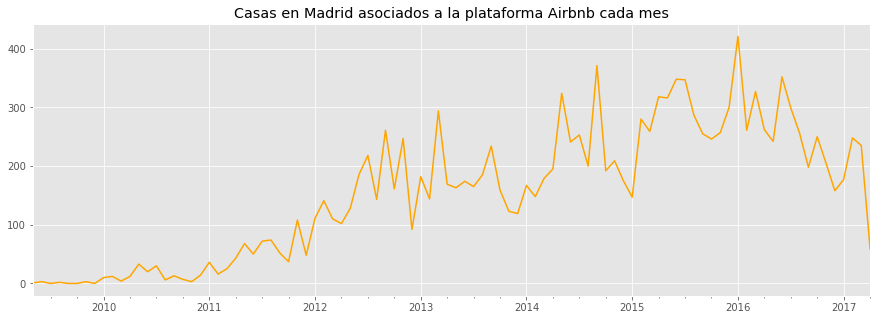

In [8]:
plt.figure(figsize=(15,5))
df_airbnb.set_index('host_since').resample('MS').size().plot(color='orange')
plt.title('Casas en Madrid asociados a la plataforma Airbnb cada mes')
plt.xlim('2009-05-17', '2017-04-10')
plt.xlabel('')
plt.ylabel('')
plt.show()

A continuación, hacemos un análisi temporal utilizando la libreria **seasonal_decompose**. Mostrando la tendencia del número de alquilerers y su estacionalidad entre los años 2009 y 2017.

In [9]:
ts_host_since = pd.DataFrame(df_airbnb.set_index('host_since').resample('MS').size())

# Renombrar columnas
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)

In [10]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.95)
    plt.subplot(311)
    plt.plot(df, label='Original', color='orange')
    plt.legend(loc='upper left')
    plt.subplot(312)
    plt.plot(trend, label='Trend', color='orange')
    plt.legend(loc='upper left')
    plt.subplot(313)
    plt.plot(seasonal,label='Seasonality', color='orange')
    plt.legend(loc='upper left')

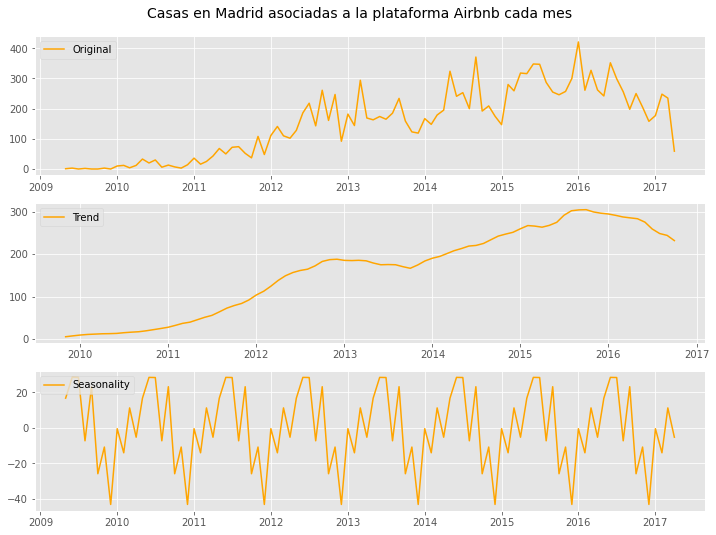

In [69]:
decompose_time_series(ts_host_since, title='Casas en Madrid asociadas a la plataforma Airbnb cada mes')

En la tendencia, se pueden apreciar dos subidas en la cantidad de casas en alquiler entre los años 2011 y 2016, con una parada en durante el año 2013. También se puede apreciar que a partir del 2016 el número de alquileres a comenzado a decrecer.
Por otro lado un claro componente estacional en el numero de casas en alquiler, aumentando a mitad de año, durante el periodo vacacional.

Revisamos la cantidad de missings en aquellas columnas que preveemos utilizar en nuestras queries.

In [12]:
df_airbnb[["ID","Neighbourhood Cleansed", "Thumbnail Url","City", "Latitude", "Longitude"]].isna().sum()

ID                           0
Neighbourhood Cleansed       0
Thumbnail Url             2820
City                         6
Latitude                     0
Longitude                    0
dtype: int64

## 2. neighbourhood.geojson + Foursquare

En este apartado cargaremos un geojson con los barrios de Madrid. De este modo calcularemos el centroide de cada barrio, y utilizaremos estos puntos para buscar los lugares de Madrid recomendados por **Foursquare**.

Para ello utilizaremos la libreria geopandas.

In [13]:
df_map = gpd.read_file(r'./datasets/neighbourhoods.geojson')
df_map.head()

,neighbourhood,neighbourhood_group,geometry
0,Palacio,Centro,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40..."
1,Embajadores,Centro,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40..."
2,Cortes,Centro,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40..."
3,Justicia,Centro,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40..."
4,Universidad,Centro,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40..."


In [14]:
# Agrupamos el dataframe df_airbnb por barrio
df_neigh = pd.DataFrame(df_airbnb.groupby('Neighbourhood Cleansed').size())
df_neigh.rename(columns={0: 'number_of_listings'}, inplace=True)
df_neigh['median_price'] = df_airbnb.groupby('Neighbourhood Cleansed').Price.median().values

# unimos los datasets
df_neigh_map = df_map.set_index('neighbourhood').join(df_neigh)

df_neigh_map.head()

,neighbourhood_group,geometry,number_of_listings,median_price
neighbourhood,,,,
Palacio,Centro,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40...",1084.0,65.0
Embajadores,Centro,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40...",1849.0,50.0
Cortes,Centro,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40...",753.0,70.0
Justicia,Centro,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40...",789.0,65.0
Universidad,Centro,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40...",1363.0,60.0


In [15]:
# el numero de barrios será
df_neigh_map.index.shape

(128,)

Representamos en un mapa la información obtenida

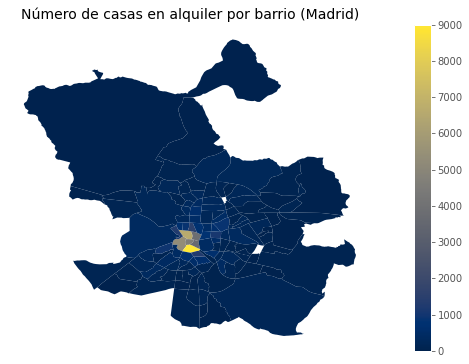

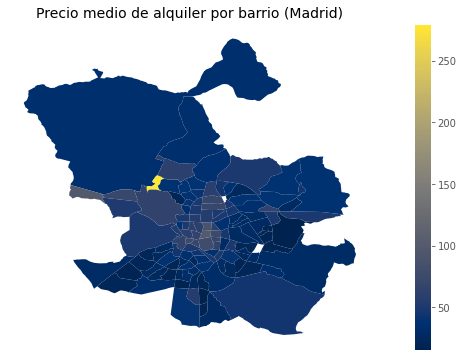

In [16]:
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
df_neigh_map.plot(column='number_of_listings', cmap='cividis', ax=ax1)
ax1.axis('off')
ax1.set_title('Número de casas en alquiler por barrio (Madrid)', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='cividis', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Precio medio de alquiler por barrio
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
df_neigh_map.plot(column='median_price', cmap='cividis', ax=ax2)
ax2.axis('off')
ax2.set_title('Precio medio de alquiler por barrio (Madrid)', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='cividis', norm=plt.Normalize(vmin=min(df_neigh_map.median_price), vmax=max(df_neigh_map.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

Calculamos los centroides por barrio, y almacenamos los resultados en un csv (neighourhood.csv) que utilizaremos, más adelante, junto con la API de Foursquare.

In [17]:
df_map["longitude"] = df_map.centroid.x
df_map["latitude"] = df_map.centroid.y

In [18]:
df_map.head()

,neighbourhood,neighbourhood_group,geometry,longitude,latitude
0,Palacio,Centro,"MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40...",-3.713981,40.415428
1,Embajadores,Centro,"MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40...",-3.702372,40.409247
2,Cortes,Centro,"MULTIPOLYGON (((-3.69796 40.41929, -3.69645 40...",-3.696740,40.414853
3,Justicia,Centro,"MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40...",-3.696569,40.423668
4,Universidad,Centro,"MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40...",-3.706979,40.425678


In [19]:
df_map[["neighbourhood","neighbourhood_group","longitude","latitude"]].to_csv("./datasets/neighbourhood.csv", index=False, sep=";", decimal=".")

Hacemos un prueba de uso de la API Foursquare. Este código será desplegado en la nube para que todos los días se ejecute y se puedan extraer los datos necesarios para nuestro análisis.

In [20]:
# Crendenciales de Foursquare 
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20200301'
LIMIT = 50

In [21]:
# Funcion que recorre los barrios y busca los lugares de interes recomendados en Foursquare.
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
poi_madrid = getNearbyVenues(names=df_map['neighbourhood'],
                                   latitudes=df_map['latitude'],
                                   longitudes=df_map['longitude'], radius = 500)

Palacio
Embajadores
Cortes
Justicia
Universidad
Sol
Imperial
Acacias
Chopera
Legazpi
Delicias
Palos de Moguer
Atocha
Pacífico
Adelfas
Estrella
Ibiza
Jerónimos
Niño Jesús
Recoletos
Goya
Fuente del Berro
Guindalera
Lista
Castellana
El Viso
Prosperidad
Pavones
Ciudad Jardín
Hispanoamérica
Nueva España
Castilla
Bellas Vistas
Cuatro Caminos
Castillejos
Vallehermoso
El Pardo
Almenara
Valdeacederas
Berruguete
Gaztambide
Arapiles
Trafalgar
Almagro
Rios Rosas
Fuentelareina
Peñagrande
Argüelles
Pilar
La Paz
Valdezarza
Valverde
Casa de Campo
Mirasierra
El Goloso
Horcajo
Ciudad Universitaria
Numancia
Valdemarín
El Plantío
Aravaca
Cármenes
Puerta del Angel
Lucero
Aluche
San Isidro
Campamento
Cuatro Vientos
Aguilas
Comillas
Opañel
Vista Alegre
Puerta Bonita
Buenavista
Abrantes
Orcasitas
Orcasur
San Fermín
Almendrales
Moscardó
Zofío
Pradolongo
Portazgo
Entrevías
San Diego
Palomeras Bajas
Palomeras Sureste
Marroquina
Media Legua
Fontarrón
Vinateros
Ventas
Pueblo Nuevo
Quintana
Concepción
San Pascual
S

Otra prueba para la extracción de lugares o puntos de interes (POI). En esta ocasión se prueba a escribir directamente los resultados en un csv. Esta es la función que finalmente se utilizará para preparar extraer los datos de Foursquare, de esta forma no almacenamos en memoria todo el dataset y no dependemos de las librerías de panda.

In [78]:
def create_csv_poi(names, latitudes, longitudes, radius):
    venues_list=[]
    with open('./datasets/poi.csv','w') as fout:
        csv_out=csv.writer(fout, delimiter=";")
        csv_out.writerow(['Neighbourhood', 
                      'Neighbourhood Latitude', 
                      'Neighbourhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category'])
    
        for name, lat, lng in zip(names, latitudes, longitudes):
            print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            venues_list = ([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            csv_out.writerows(venues_list)

In [75]:


create_csv_poi(names=df_map['neighbourhood'],
                                   latitudes=df_map['latitude'],
                                   longitudes=df_map['longitude'], radius = 500)


Palacio
Embajadores
Cortes
Justicia
Universidad
Sol
Imperial
Acacias
Chopera
Legazpi
Delicias
Palos de Moguer
Atocha
Pacífico
Adelfas
Estrella
Ibiza
Jerónimos
Niño Jesús
Recoletos
Goya
Fuente del Berro
Guindalera
Lista
Castellana
El Viso
Prosperidad
Pavones
Ciudad Jardín
Hispanoamérica
Nueva España
Castilla
Bellas Vistas
Cuatro Caminos
Castillejos
Vallehermoso
El Pardo
Almenara
Valdeacederas
Berruguete
Gaztambide
Arapiles
Trafalgar
Almagro
Rios Rosas
Fuentelareina
Peñagrande
Argüelles
Pilar
La Paz
Valdezarza
Valverde
Casa de Campo
Mirasierra
El Goloso
Horcajo
Ciudad Universitaria
Numancia
Valdemarín
El Plantío
Aravaca
Cármenes
Puerta del Angel
Lucero
Aluche
San Isidro
Campamento
Cuatro Vientos
Aguilas
Comillas
Opañel
Vista Alegre
Puerta Bonita
Buenavista
Abrantes
Orcasitas
Orcasur
San Fermín
Almendrales
Moscardó
Zofío
Pradolongo
Portazgo
Entrevías
San Diego
Palomeras Bajas
Palomeras Sureste
Marroquina
Media Legua
Fontarrón
Vinateros
Ventas
Pueblo Nuevo
Quintana
Concepción
San Pascual
S

[[('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Santa Iglesia Catedral de Santa María la Real de la Almudena (Catedral de la Almudena)',
   40.41576693264202,
   -3.7145161628723145,
   'Church'),
  ('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Cervecería La Mayor',
   40.41521786102789,
   -3.7121938520878386,
   'Beer Bar'),
  ('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Mercado Jamón Iberico',
   40.41544225,
   -3.71164314,
   'Market'),
  ('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Plaza de La Almudena',
   40.41631960737639,
   -3.713776929870609,
   'Plaza'),
  ('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Palacio Real de Madrid',
   40.41793972010854,
   -3.714258670806885,
   'Palace'),
  ('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Charlie Champagne',
   40.41393640099747,
   -3.712647348286377,
   'Restaurant'),
  ('Palacio',
   40.41542813957815,
   -3.713981305934884,
   'Plaza de

Analizamos los lugares obtenidos en Foursquare

In [25]:
print(poi_madrid.shape)
poi_madrid.head()

(2604, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palacio,40.415428,-3.713981,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,Palacio,40.415428,-3.713981,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
2,Palacio,40.415428,-3.713981,Mercado Jamón Iberico,40.415442,-3.711643,Market
3,Palacio,40.415428,-3.713981,Plaza de La Almudena,40.416320,-3.713777,Plaza
4,Palacio,40.415428,-3.713981,Palacio Real de Madrid,40.417940,-3.714259,Palace


In [26]:
# Guardamos los datos
poi_madrid.to_csv(r'./datasets/poi_madrid.csv')

In [27]:
# Read dataset
poi_madrid = pd.read_csv('./datasets/poi_madrid.csv', index_col=0)

Analizamos los lugares recomedados por vecindario

In [51]:
poi_madrid_grouped = poi_madrid.groupby('Neighbourhood').count()

In [52]:
poi_madrid_grouped.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Abrantes,7,7,7,7,7,7
Acacias,50,50,50,50,50,50
Adelfas,36,36,36,36,36,36
Aeropuerto,2,2,2,2,2,2
Aguilas,8,8,8,8,8,8


In [53]:
poi_madrid_grouped.index.rename('neighbourhood', inplace=True)

# unimos los datasets para poder representarlos en un mapa
df_poi_map = df_map.set_index('neighbourhood').join(poi_madrid_grouped)

Representamos la cantidad de lugares de interes recomendados por barrio.

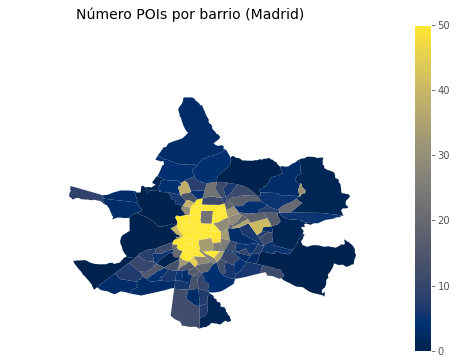

In [50]:
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
df_poi_map.plot(column='Venue', cmap='cividis', ax=ax1)
ax1.axis('off')
ax1.set_title('Número POIs por barrio (Madrid)', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='cividis', norm=plt.Normalize(vmin=0, vmax=50))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

Mediante Foursquare tenemos un límite de 50 lugares por punto, de modo que en muchos barrios ya estamos llegando al límite. Una mejora a valorar sería aumentar cantidad de lugares recomendados extraídos. Por ejemplo en lugar de hacerlo a través del centroide de cada barrio nos podriamos crear una rejilla con mayor resolución sobre la cual extraeríamos las recomendaciones de Foursquare.

Como era de esperar los barrios con más lugares recomendados son los del centro de Madrid.

#### Número de categorías

In [32]:
print('Hay {} categorias distintas'.format(len(poi_madrid['Venue Category'].unique())))

Hay 258 categorias distintas


Top 10 de categorias de los luegares obtenidos

In [29]:
poi_madrid.groupby('Venue Category')['Venue Category'].count().nlargest(10)

Venue Category
Spanish Restaurant    275
Restaurant            162
Bar                   108
Tapas Restaurant      106
Café                   75
Bakery                 68
Hotel                  68
Park                   68
Pizza Place            66
Coffee Shop            65
Name: Venue Category, dtype: int64

In [31]:
poi_madrid['Venue Category'].value_counts()

Spanish Restaurant          275
Restaurant                  162
Bar                         108
Tapas Restaurant            106
Café                         75
Park                         68
Hotel                        68
Bakery                       68
Pizza Place                  66
Coffee Shop                  65
Grocery Store                63
Supermarket                  55
Plaza                        50
Italian Restaurant           49
Mediterranean Restaurant     35
Burger Joint                 32
Gym / Fitness Center         31
Fast Food Restaurant         31
Gym                          30
Japanese Restaurant          30
Seafood Restaurant           29
Asian Restaurant             28
Chinese Restaurant           28
Cocktail Bar                 25
Brewery                      25
Pub                          24
Ice Cream Shop               23
Breakfast Spot               22
Gastropub                    22
Diner                        22
Sandwich Place               20
Bookstor

## 3. Agenda de actividades y eventos de Madrid

In [54]:
df_events = pd.read_csv('./datasets/events.csv',sep=';',decimal='.')

In [55]:
df_events.shape

(1000, 30)

In [57]:
df_events.head()

,ID-EVENTO,TITULO,PRECIO,GRATUITO,LARGA-DURACION,DIAS-SEMANA,DIAS-EXCLUIDOS,FECHA,FECHA-FIN,HORA,DESCRIPCION,CONTENT-URL,TITULO-ACTIVIDAD,URL-ACTIVIDAD,URL-INSTALACION,NOMBRE-INSTALACION,ACCESIBILIDAD-INSTALACION,CLASE-VIAL-INSTALACION,NOMBRE-VIA-INSTALACION,NUM-INSTALACION,DISTRITO-INSTALACION,BARRIO-INSTALACION,CODIGO-POSTAL-INSTALACION,COORDENADA-X,COORDENADA-Y,LATITUD,LONGITUD,TIPO,AUDIENCIA,Unnamed: 29
0,11142642,10 años de jazz: Jazz Band,NaN,1,0,NaN,NaN,2020-03-31 00:00:00.0,2020-03-31 23:59:00.0,19:00,NaN,http://www.madrid.es/sites/v/index.jsp?vgnextc...,NaN,NaN,http://www.madrid.es/sites/v/index.jsp?vgnextc...,Centro Cultural Fernando Lázaro Carreter (Cara...,1,CALLE,VERDAD,29.0,CARABANCHEL,OPAÑEL,28019.0,439136.0,4471474.0,40.391643,-3.717141,/contenido/actividades/Musica,NaN,NaN
1,11142634,10 años de rock: Código de birras,NaN,1,0,NaN,NaN,2020-03-20 00:00:00.0,2020-03-20 23:59:00.0,19:00,NaN,http://www.madrid.es/sites/v/index.jsp?vgnextc...,NaN,NaN,http://www.madrid.es/sites/v/index.jsp?vgnextc...,Centro Cultural Fernando Lázaro Carreter (Cara...,1,CALLE,VERDAD,29.0,CARABANCHEL,OPAÑEL,28019.0,439136.0,4471474.0,40.391643,-3.717141,/contenido/actividades/Musica,NaN,NaN
2,11152105,11 M. La memoria imborrable,NaN,0,0,NaN,NaN,2020-03-11 00:00:00.0,2020-03-11 23:59:00.0,13:30,NaN,http://www.madrid.es/sites/v/index.jsp?vgnextc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11110659,"2020, año galdosiano, madrileño y novelesco",NaN,1,1,M,NaN,2020-01-21 00:00:00.0,2020-04-07 23:59:00.0,NaN,A las 19 horas y en las fechas abajo indicadas...,http://www.madrid.es/sites/v/index.jsp?vgnextc...,2020: Año galdosiano,http://www.madrid.es/sites/v/index.jsp?vgnextc...,http://www.madrid.es/sites/v/index.jsp?vgnextc...,Casa de La Villa. Ayuntamiento de Madrid,0,PLAZA,VILLA,5.0,CENTRO,PALACIO,28005.0,439711.0,4474084.0,40.415188,-3.710625,/contenido/actividades/ConferenciasColoquios,NaN,NaN
4,11138269,3º Encuentro de Coros infantiles y juveniles,NaN,1,0,NaN,NaN,2020-03-27 00:00:00.0,2020-03-27 23:59:00.0,19:00,Coro Infantil Turina / Coro Infantil Sagunto /...,http://www.madrid.es/sites/v/index.jsp?vgnextc...,Actividades en el Centro Cultural Valdebernard...,http://www.madrid.es/sites/v/index.jsp?vgnextc...,http://www.madrid.es/sites/v/index.jsp?vgnextc...,Centro Cultural Valdebernardo (Vicálvaro),1,BULEVAR,INDALECIO PRIETO,21.0,VICALVARO,CASCO H.VICALVARO,28032.0,447278.0,4472321.0,40.399829,-3.621282,/contenido/actividades/TeatroPerformance,/usuario/Niños,NaN


Las columnas que nos interesan de este dataset serán:
FECHA, FECHA-FIN, LATITUD, LONGITID y TIPO

A continuación hacemos una pequeña exploración para saber si este dataset presenta duplicidades o si las columnas que nos interesan tienen muchos missings.

In [71]:
df_events.duplicated().sum()

0

In [58]:
df_events[["FECHA","FECHA-FIN", "LATITUD","LONGITUD", "TIPO"]].isna().sum()

FECHA         0
FECHA-FIN     0
LATITUD      31
LONGITUD     31
TIPO         44
dtype: int64

Podemos comprobar que la cantidad de filas sin información no es demasiado relevante (3% aprox.). Estas filas serán descartadsa cuando se realice el análisis desde Hive.

In [59]:
df_events['fecha_ini'] = pd.to_datetime(df_events['FECHA'])
df_events['fecha_fin'] = pd.to_datetime(df_events['FECHA-FIN'])

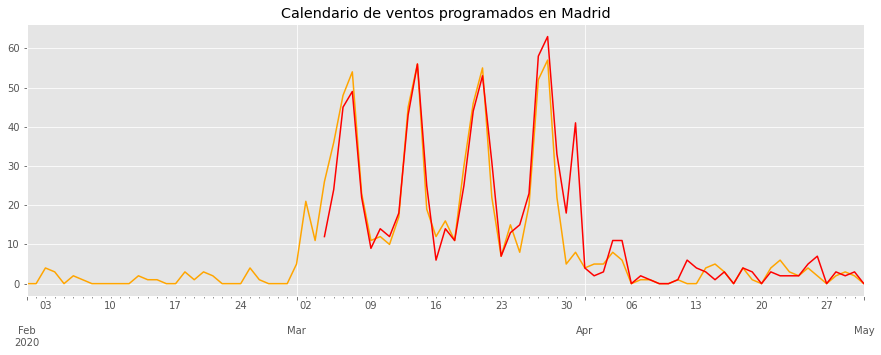

In [61]:
plt.figure(figsize=(15,5))
df_events.set_index('fecha_ini').resample('D').size().plot(label='Comienzo de eventos', color='orange')
df_events.set_index('fecha_fin').resample('D').size().plot(label='Finalización de eventos', color='red')
plt.title('Calendario de ventos programados en Madrid')
plt.xlim('2020-02-01', '2020-05-01')
plt.xlabel('')
plt.ylabel('')
plt.show()

Nos interesa saber las categorias de eventos de este dataset

In [66]:
print('Hay {} categorias distintas'.format(len(df_events['TIPO'].unique())))
df_events['TIPO'].value_counts()

Hay 41 categorias distintas


/contenido/actividades/CursosTalleres                              162
/contenido/actividades/ProgramacionDestacadaAgendaCultura          134
/contenido/actividades/ConferenciasColoquios                       104
/contenido/actividades/TeatroPerformance                            91
/contenido/actividades/Musica                                       74
/contenido/actividades/ItinerariosOtrasActividadesAmbientales       71
/contenido/actividades/Exposiciones                                 62
/contenido/actividades/CuentacuentosTiteresMarionetas               43
/contenido/actividades/CineActividadesAudiovisuales                 39
/contenido/actividades/ComemoracionesHomenajes                      25
/contenido/actividades/DanzaBaile                                   23
/contenido/actividades/RecitalesPresentacionesActosLiterarios       20
/contenido/actividades/Campamentos                                  16
/contenido/actividades/CircoMagia                                   11
/conte

Seleccionaremos aquellos que consideremos más relevante para la oferta de ocio a tener en cuenta en las recomendaciones.

In [72]:
# Seleccionaremos las siguientes actividades
terms = ['Exposiciones', 'TeatroPereformance', 'Circo', 'Teatro', 'Musica', 'Musica', 'Marionetas']
df_events_filtered = df_events[df_events['TIPO'].str.contains('|'.join(terms), na=False)]
df_events_filtered['TIPO'].value_counts()

/contenido/actividades/TeatroPerformance                    91
/contenido/actividades/Musica                               74
/contenido/actividades/Exposiciones                         62
/contenido/actividades/CuentacuentosTiteresMarionetas       43
/contenido/actividades/CircoMagia                           11
/contenido/actividades/TeatroPerformance/ComediaMonologo     6
/contenido/actividades/Musica/Flamenco                       6
/contenido/actividades/Musica/CantautorFolkCountry           5
/contenido/actividades/Musica/Zarzuela                       4
/contenido/actividades/Musica/Clasica                        3
/contenido/actividades/Musica/JazzSoulFunkySwingReagge       2
/contenido/actividades/Musica/LatinaEspanola                 2
Name: TIPO, dtype: int64